# Projection On Capped Simplex

In [1]:
import numpy as np
from tqdm import tqdm

N = 1000
C = 100
w_n = 1
eps = 1e-32
T = 2 * 10 ** 4

def custom_zipf(N: int, a: float, T: int):
    """Generate a custom zipf"""
    ns = np.arange(N)
    ps = (1 / (ns+1) ** a) 
    ps = ps / sum(ps)
    return np.random.choice(ns, size=T, p=ps)
#REQUESTS = np.random.random_integers(0,N, T)
#REQUESTS = np.concatenate(
#        [custom_zipf(N, 0.64, T // 2),
#         custom_zipf(N, 0.82, T//2)
#        #np.random.random_integers(0,N, T//2)
#         ]) #np.random.zipf(1.2, T)
REQUESTS = custom_zipf(N, 0.64, T)
#N = max(REQUESTS)

print("MAX:", max(REQUESTS)) #np.array([1.2,0.0,0.0,0.0,0.0,.0,.0,.0,.0,.0])
#REQUESTS = REQUESTS[REQUESTS < N] 

MAX: 999


In [2]:
import time
loop1, loop2 = 0,0

def oga_epoch(Z: np.ndarray):
    """
    """

    zdx = np.argsort(Z, kind="heapsort")[::-1]
    sorted_z = Z[zdx]
    y = np.zeros(N)
    M1 = set()
    M2 = set(range(N))
    M3 = set()
    
    while True:

        if not M2:
            break

        rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

        #for n in range(N):
        #    if n in M1:
        #        y[n] = 1
        #    elif n in M2:
        #        y[n] = sorted_z[n] - rho / 2
        #    elif n in M3:
        #        y[n] = 0

        y[list(M1)] = 1
        y[list(M2)] = sorted_z[list(M2)] - rho / 2
        y[list(M3)] = 0

        S = {n for n in M2 if y[n] < 0}
        M2.difference_update(S)
        M3.update(S)

        if not S:
            break
        
        
    if y[0] > 1:
        M1 = {0}
        M2 = set(range(1,N))
        M3 = set()
        while True:

            if not M2:
                break

            rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

            y[list(M1)] = 1
            y[list(M2)] = sorted_z[list(M2)] - rho / 2
            y[list(M3)] = 0

            S = {n for n in M2 if y[n] < 0}
            M2.difference_update(S)
            M3.update(S)

            if not S:
                break
    og_order = np.zeros(N)
    for i, val in zip(zdx, y):
        og_order[i] = val

    return og_order


(array([617., 414., 296., 279., 253., 227., 183., 166., 162., 128., 155.,
        137., 116., 115.,  99., 123., 125.,  96., 116., 115.,  86.,  93.,
         84.,  79.,  80.,  71.,  74.,  73.,  77.,  62.,  70.,  65.,  61.,
         56.,  64.,  68.,  68.,  79.,  61.,  64.,  61.,  59.,  70.,  46.,
         63.,  59.,  52.,  51.,  48.,  52.,  44.,  42.,  43.,  41.,  53.,
         44.,  50.,  41.,  51.,  43.,  47.,  42.,  53.,  34.,  54.,  39.,
         35.,  39.,  45.,  36.,  41.,  48.,  51.,  42.,  36.,  43.,  46.,
         37.,  38.,  36.,  28.,  39.,  34.,  37.,  50.,  28.,  36.,  36.,
         27.,  56.,  40.,  35.,  41.,  38.,  30.,  39.,  34.,  26.,  38.,
         37.,  42.,  40.,  32.,  35.,  24.,  40.,  36.,  33.,  30.,  34.,
         27.,  29.,  26.,  21.,  26.,  30.,  29.,  32.,  34.,  26.,  27.,
         35.,  35.,  26.,  33.,  26.,  31.,  30.,  29.,  31.,  22.,  32.,
         32.,  31.,  34.,  33.,  19.,  35.,  19.,  29.,  30.,  16.,  30.,
         25.,  26.,  25.,  19.,  40., 

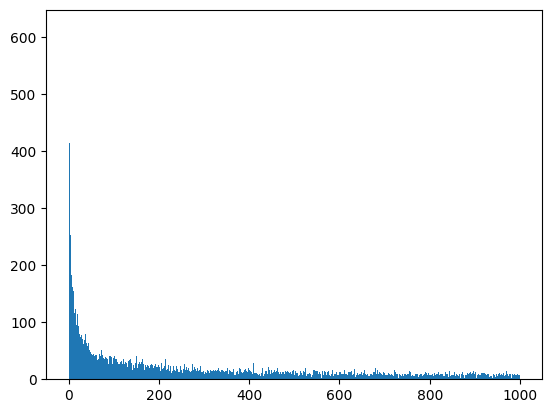

In [3]:
import matplotlib.pyplot as plt
plt.hist(REQUESTS, bins=N)

In [4]:
conv_rates = {}

In [5]:


Z = np.zeros(N)
y = np.zeros(N)
M1, M2, M3 = set(), set(), set()

print("OGA Implementation")
hits = [] 
rolling_avg = {"oga":[], "lru":[], "lfu":[], "static":[]}
eta = 0.1
y_map = []
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
for idx, req in pbar:

    hits.append(y[req - 1])
    y[req - 1] += eta * w_n * y[req - 1]
    y_map.append(y)
    #hits.append(1 if (req - 1) in M2 else 0)
    hits = hits[-1000:]
    rolling_avg["oga"].append(sum(hits) / (len(hits) + 1))
    y = oga_epoch(y)
    pbar.set_description(f"Loop1: {loop1} | Loop2: {loop2} | Avg Hits: {sum(hits) / (len(hits) + 1)} | sigma y: {sum(y)}")

conv_rates[eta] = rolling_avg["oga"][:]


OGA Implementation


Loop1: 0 | Loop2: 0 | Avg Hits: 0.10219354677927331 | sigma y: 99.99999999999875:   1%|          | 132/20000 [00:00<00:15, 1311.73it/s] 

Loop1: 0 | Loop2: 0 | Avg Hits: 0.3873663001686629 | sigma y: 100.00000000000003: 100%|██████████| 20000/20000 [00:20<00:00, 992.80it/s]  


Text(0.5, 1.0, 'OGA Decision Vector / Time')

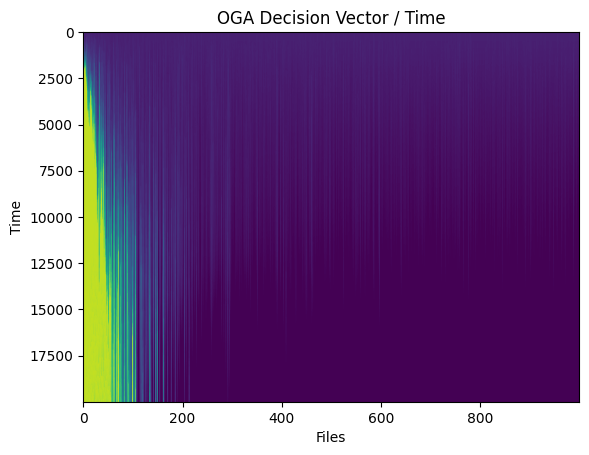

In [15]:
y_map = np.array(y_map)
plt.imshow(y_map, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("OGA Decision Vector / Time")

In [12]:
lru_cache = []
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

lru_ymap = []

for idx, req in pbar:
    if (req - 1) in lru_cache:
        hits.append(1)
        lru_cache = list(filter(lambda item: item != req - 1, lru_cache))
        lru_cache.append(req - 1)
    else:
        hits.append(0)
        lru_cache.append(req - 1)

    hits = hits[-1000:]
    rolling_avg["lru"].append(sum(hits) / (len(hits)+1))
    lru_cache = lru_cache[-C:]
    #heatmap
    y = np.zeros(N)
    y[lru_cache] = 1.
    lru_ymap.append(y)

    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)} | {len(lru_cache)}")



Avg Hits: 0.23876123876123875 | 100: 100%|██████████| 20000/20000 [00:06<00:00, 2927.44it/s]


Text(0.5, 1.0, 'RLU Decision Vector / Time')

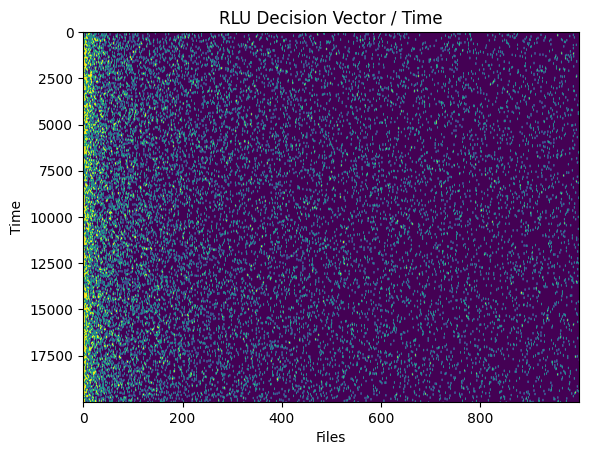

In [16]:
lru_ymap = np.array(lru_ymap)

plt.imshow(lru_ymap, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("LRU Decision Vector / Time")

In [18]:
#LFU
freqs = np.zeros(N)
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []
lfu_ymap = []

for idx, req in pbar:

    if req-1 in np.argsort(freqs)[-C:]:
        hits.append(1)
    else:
        hits.append(0)

    y = np.zeros(N)
    y[np.argsort(freqs)[-C:]] = 1.

    lfu_ymap.append(y)
    hits = hits[-1000:]
    rolling_avg["lfu"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")
    freqs[req - 1] += 1




Avg Hits: 0.36063936063936064: 100%|██████████| 20000/20000 [00:08<00:00, 2354.99it/s]


In [ ]:
lfu_ymap = np.array(lfu_ymap)

plt.imshow(lfu_ymap, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("LFU Decision Vector / Time")

In [ ]:
#static policy
_ , counts = np.unique(REQUESTS, return_counts=True)
static_cache = np.argsort(counts)[-C:]

pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

for idx, req in pbar:

    if req-1 in static_cache:
        hits.append(1)
    else:
        hits.append(0)

    hits = hits[-1000:]
    rolling_avg["static"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")



Avg Hits: 0.6653346653346653: 100%|██████████| 20000/20000 [00:06<00:00, 3161.56it/s]


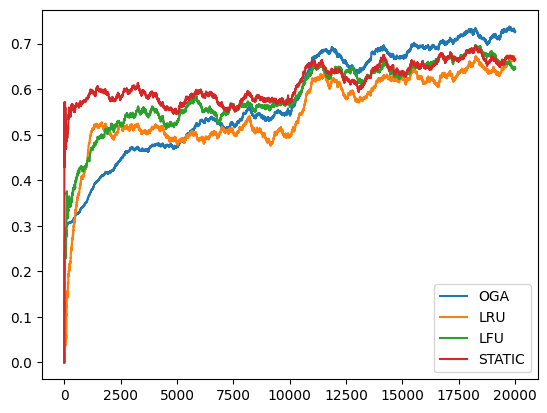

In [ ]:
for name, data in rolling_avg.items():
    plt.plot(data, label=name.upper())

plt.legend()